In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Embedding ,GRU
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import os


In [ ]:
# Load dataset (assuming a CSV file with a column 'number')
def load_data(file_path):
    df = pd.read_csv(file_path, header=None, names=['number'])
    df['parity'] = df['number'] % 2  # 0 for even, 1 for odd
    return df

In [ ]:
feature_file = 'processed_features.csv'
file_path = 'random_numbers.csv'
history_size = 32

In [ ]:

# Check if processed feature file exists
if os.path.exists(feature_file):
    print("Loading precomputed features...")
    feature_data = pd.read_csv(feature_file, header=None)
    X = feature_data.iloc[:, :-1].values
    y = feature_data.iloc[:, -1].values
else:
    print("Processing features from scratch...")
    data = load_data(file_path)

    X, y = [], []
    for i in range(history_size, len(data) - 1):  # Ensure next value is available
        # Features: Last 'history_size' numbers + last 'history_size' parity values
        features = np.concatenate((
            data['number'].iloc[i-history_size:i].values,  # Last N numbers
            data['parity'].iloc[i-history_size:i].values   # Last N parity values
        ))
        X.append(features)

        # Target: Parity of the next number
        y.append(data['parity'].iloc[i + 1])

    X, y = np.array(X), np.array(y)

    # Save processed features
    feature_df = pd.DataFrame(np.column_stack((X, y)))
    feature_df.to_csv(feature_file, index=False, header=False)


Loading precomputed features...


In [ ]:

# Train-test split (50% training, 50% testing)
train_size = int(len(X) * 0.5)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Store results
results = {}

In [ ]:
print(X[:5])

[[1170412804 1263216529 1241532358 1980132081 2036180451 1408798643
  1030900989  639902848 1731283150 1432957307  916250677  429621378
  1071909914  536360637 2063961082 1289408060  902687052 1282787416
  1219327459  825674994   42395416  132035513 1345372917  398791395
  1825245376   51647478  395980081 1830126729 1191585949  179555925
  1086426591  214515106          0          1          0          1
           1          1          1          0          0          1
           1          0          0          1          0          0
           0          0          1          0          0          1
           1          1          0          0          1          1
           1          1          1          0]
 [1263216529 1241532358 1980132081 2036180451 1408798643 1030900989
   639902848 1731283150 1432957307  916250677  429621378 1071909914
   536360637 2063961082 1289408060  902687052 1282787416 1219327459
   825674994   42395416  132035513 1345372917  398791395 1825245376
 

In [ ]:

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=500)
}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f'{name} Accuracy: {accuracy:.4f}')


Logistic Regression Accuracy: 0.5000
Random Forest Accuracy: 0.5496
Neural Network Accuracy: 0.5002


In [ ]:
# LSTM Model (without Embedding)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=0)
lstm_accuracy = lstm_model.evaluate(X_test_reshaped, y_test, verbose=0)[1]
print(f'LSTM Accuracy: {lstm_accuracy:.4f}')

# BiLSTM Model (without Embedding)
bilstm_model = Sequential([
    Bidirectional(LSTM(32, return_sequences=False, input_shape=(X_train.shape[1], 1))),
    Dense(1, activation='sigmoid')
])
bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=0)
bilstm_accuracy = bilstm_model.evaluate(X_test_reshaped, y_test, verbose=2)[1]
print(f'BiLSTM Accuracy: {bilstm_accuracy:.4f}')

# GRU Model (without Embedding)
gru_model = Sequential([
    GRU(32, return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dense(1, activation='sigmoid')
])
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=2)
gru_accuracy = gru_model.evaluate(X_test_reshaped, y_test, verbose=2)[1]
print(f'GRU Accuracy: {gru_accuracy:.4f}')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM Accuracy: 0.4999
31250/31250 - 138s - 4ms/step - accuracy: 0.5001 - loss: 0.6932
BiLSTM Accuracy: 0.5001
Epoch 1/10
31250/31250 - 177s - 6ms/step - accuracy: 0.5000 - loss: 0.6932
Epoch 2/10
31250/31250 - 176s - 6ms/step - accuracy: 0.5012 - loss: 0.6932
Epoch 3/10
31250/31250 - 202s - 6ms/step - accuracy: 0.4996 - loss: 0.6932
Epoch 4/10
31250/31250 - 176s - 6ms/step - accuracy: 0.5003 - loss: 0.6932
Epoch 5/10
31250/31250 - 201s - 6ms/step - accuracy: 0.5000 - loss: 0.6932
Epoch 6/10
31250/31250 - 201s - 6ms/step - accuracy: 0.5000 - loss: 0.6932
Epoch 7/10
31250/31250 - 202s - 6ms/step - accuracy: 0.4996 - loss: 0.6932
Epoch 8/10
31250/31250 - 202s - 6ms/step - accuracy: 0.5005 - loss: 0.6932
Epoch 9/10
31250/31250 - 202s - 6ms/step - accuracy: 0.5000 - loss: 0.6932
Epoch 10/10
31250/31250 - 176s - 6ms/step - accuracy: 0.4998 - loss: 0.6932
31250/31250 - 111s - 4ms/step - accuracy: 0.4999 - loss: 0.6932
GRU Accuracy: 0.4999


<ipython-input-5-6b0b3063c9c6>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette="coolwarm")


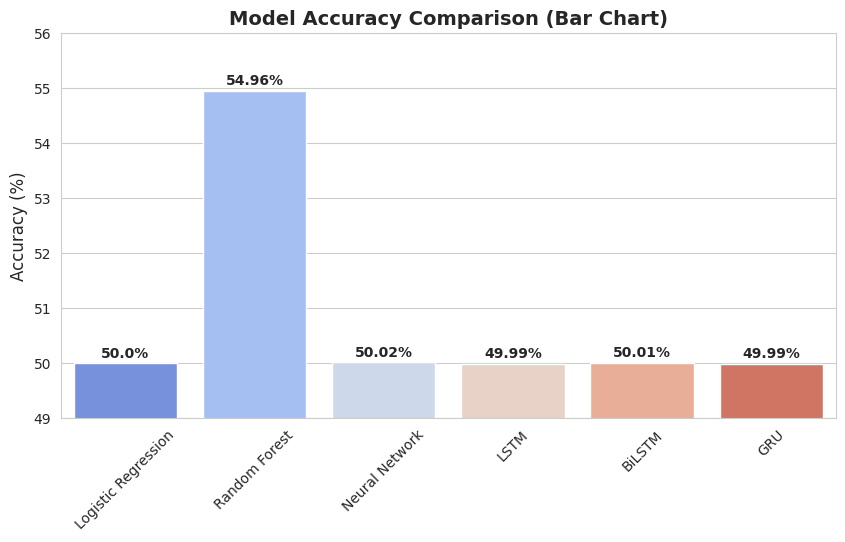

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy results in percentage (rounded to 2 decimal places)
results = {
    'Logistic Regression': round(0.5000 * 100, 2),
    'Random Forest': round(0.5496 * 100, 2),
    'Neural Network': round(0.5002 * 100, 2),
    'LSTM': round(0.4999 * 100, 2),
    'BiLSTM': round(0.5001 * 100, 2),
    'GRU': round(0.4999 * 100, 2)
}

model_names = list(results.keys())
accuracies = list(results.values())

# Set style
sns.set_style("whitegrid")

# Create Bar Graph
plt.figure(figsize=(10, 5))
sns.barplot(x=model_names, y=accuracies, palette="coolwarm")
plt.title("Model Accuracy Comparison (Bar Chart)", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(49, 56)
plt.xticks(rotation=45)

# Add text labels on bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.1, f"{v}%", ha='center', fontsize=10, fontweight='bold')

plt.show()


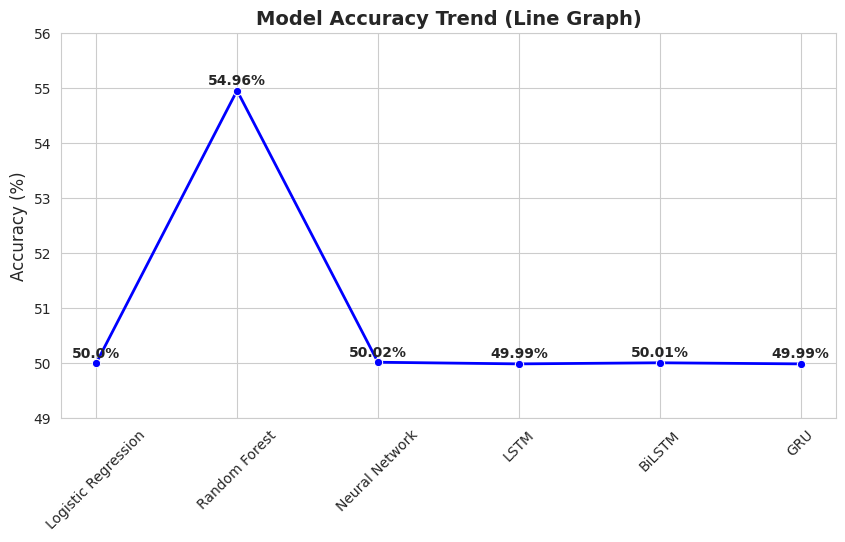

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Create Line Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=model_names, y=accuracies, marker="o", color="b", linewidth=2)

plt.title("Model Accuracy Trend (Line Graph)", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(49, 56)
plt.xticks(rotation=45)

# Add text labels
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.1, f"{v}%", ha='center', fontsize=10, fontweight='bold')

plt.show()


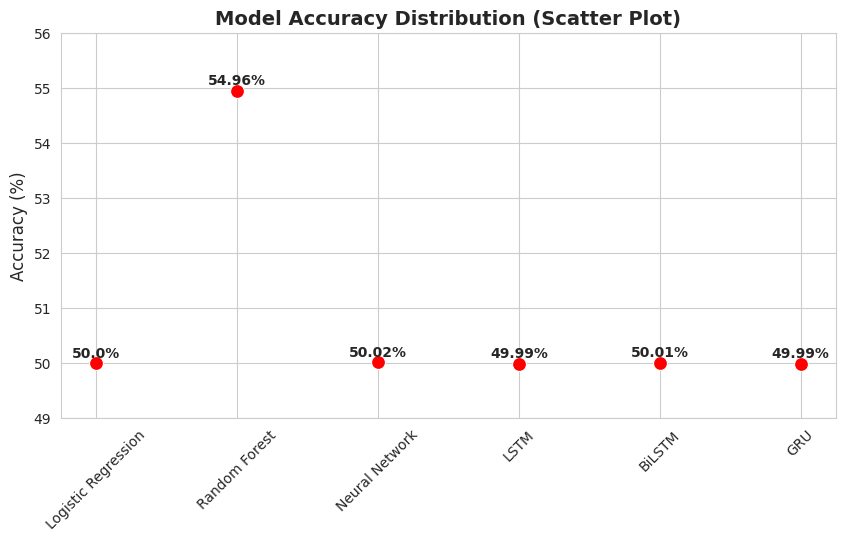

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Create Scatter Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x=model_names, y=accuracies, color="red", s=100)

plt.title("Model Accuracy Distribution (Scatter Plot)", fontsize=14, fontweight="bold")
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(49, 56)
plt.xticks(rotation=45)

# Add text labels
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.1, f"{v}%", ha='center', fontsize=10, fontweight='bold')

plt.show()
